In [1]:
%load_ext autoreload
%autoreload 2
# %cd /p/mmcardiac/Jerry/code/CINE-DENSE-Translation
%cd /home/jx8fh/Projects/LaMoD
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from modules.data import check_dict

/sfs/gpfs/tardis/home/jx8fh/Projects/LaMoD


In [2]:
# USE GPU 0
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
!gpustat

udc-an28-1                Wed Nov 13 21:12:36 2024  550.54.14
[0] NVIDIA A100-SXM4-40GB | 35°C,   0 % |   119 / 40960 MB | gdm(106M)


In [4]:
test_fname = '/scratch/jx8fh/2024-11-10-cine-to-extract-motion-128.npy'
test_data = np.load(test_fname, allow_pickle=True).tolist()

In [5]:
import json
config_fname = 'configs/ours-LaMoD.json'
config = json.load(open(config_fname))

In [6]:
from models.LaMoD import LaMoD
network = LaMoD(config['networks'], device).to(device)

Skip connect: False
Loading pretrained model from checkpoints/ours_registration.pth
Unrecognized keyword argument: beta_schedule_overwrite = True
Unrecognized keyword argument: load_pretrained = True
Unrecognized keyword argument: pretrained_model_path = checkpoints/ours_latent_diffusion.pth
beta_schedule_method='linear'
Loading pretrained model from checkpoints/ours_latent_diffusion.pth


/home/jx8fh/.conda/envs/cardiac/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Overwriting beta schedule with linear schedule with scale 30
ignorekwargs: {'type': 'DiffusionDecoder', 'drouput': 0.3, 'load_pretrained': True, 'pretrained_model_path': 'checkpoints/ours_motion_regression.pth'}
Decoder tanh_out:  False
Decoder: give_pre_end=False, tanh_out=False, out_scaling_factor=1
Working with z of shape (1, 16, 16, 16) = 4096 dimensions.
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 256 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 128 in_channels
making attention of type 'vanilla' with 64 in_channels
making attention of type 'vanilla' with 64 in_channels
making attention of type 'vanilla' with 64 in_channels
Loading pretrained model from checkpoints/ours_motion_regression.pth


In [7]:
from skimage.transform import resize
check_data_idx = 1
inference_mask = torch.from_numpy(
    resize(test_data[check_data_idx]['mask'][...,0] > 0.5, [48,48], anti_aliasing=False)
)

In [43]:
# check_data_idx = 1

# Prepare Pytorch tensor
inference_input_video      = torch.from_numpy(test_data[check_data_idx]['mask']).to(device).moveaxis(-1,0)[None]
# inference_input_video_ori_frame = test_data[check_data_idx]['ori_n_frames']
inference_input_video_ori_frame = test_data[check_data_idx]['mask'].shape[-1]
inference_output_dict = network.inference(
    inference_input_video, 
    ori_n_frames=[inference_input_video_ori_frame],
    skip_diffusion=True)[0]

# Extract prediction
inference_disp = inference_output_dict['LaMoD_disp'].detach().cpu()

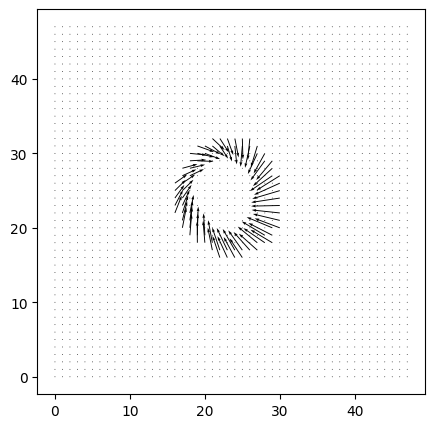

In [44]:
# Visualize 
check_frame_idx = 20
fig, axs = plt.subplots(1, 1, figsize=(5,5))
# Prediction
axs.quiver(
    inference_disp[0,0,check_frame_idx]*inference_mask,
    inference_disp[0,1,check_frame_idx]*inference_mask,
    units='xy',
    scale=1
)